In [1]:
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd
import time

In [2]:
#Check if the team is in the golden zone (c.f. Champion Golden Zone for more explanations on the numbers)
def contender_zone(off_ratings,def_ratings):
    L=[]
    for i in range(len(off_ratings)):
        if (off_ratings[i]-1)**2+(def_ratings[i]-1)**2<=.52**2:
            L.append(True)
        else:
            L.append(False)
    return L

In [3]:
def normalize_ratings(c1,defensive):
    
    #Takes a list, normalizes it and returns the normalized list
    
    
    Max_c1 = max(c1)
    Min_c1 = min(c1)

    n_c1 = []
    for i in c1:
                
        normalized_c1 = (i-Min_c1) / (Max_c1-Min_c1) if Max_c1!=Min_c1 else 0
        
        #If we are normalizing defensive winrate, reverse the values (so that best defenses get 1 instead of 0)
        if defensive:
            n_c1.append(1-normalized_c1)
        else:
            n_c1.append(normalized_c1)
    
    return n_c1

## Now we do it, not just at Christmas, but for every 2 weeks in the season, so we can visually see the change in contenders, and assess when are the final contenders set in the cmapionship zone. We can then conclude when it is late enough to call them contenders.

In [4]:
from datetime import datetime, timedelta

def bimonthly_dates(start_date: str, end_date: str):
    #Prints all dates from start_date to end_date separated by 2 weeks.
    
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    # Initialize current date to start date and list
    current_date = start + timedelta(weeks=2)
    List=[]
    
    
    # Iterate over dates in bimonthly intervals
    while current_date <= end:
        List.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(weeks=2)

    # Print the overstepping date if it exists
    if current_date > end:
        List.append(current_date.strftime("%Y-%m-%d"))
    
    #Return the list
    return(List)

# Example usage
#bimonthly_dates("2020-12-01", "2021-06-01")

### Example with the year 2018, before expanding to every year we can

In [5]:
from nba_api.stats.endpoints import leaguegamefinder

def get_regular_season_dates(year: int):
    
    # Query games from the given season
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=f"{year-1}-{str(year )[-2:]}", season_type_nullable="Regular Season")
    games = gamefinder.get_data_frames()[0]  # Get the data as a DataFrame
    
    # Extract game dates and convert to datetime
    game_dates = games['GAME_DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    # Find the earliest and latest dates
    start_date = game_dates.min()
    end_date = game_dates.max()
    
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

# Example
#start, end = get_regular_season_dates(2018)
#print(f"Start Date: {start}")
#print(f"End Date: {end}")

In [133]:
from nba_api.stats.endpoints import leaguegamefinder

def get_conference_finalists(year):
    
    conf_finalists=[]
    
    #Get this year's champion (idk why it's not updated for 2024 ... The playoff games are in but not the champ in teams.py)
    if year == 2024:
        champ="Boston Celtics"
    else:
        champ = teams._find_teams_by_championship_year(year)
        
    conf_finalists.append(champ)

    # Fetch the playoff picture for the given year
    gamefinder = leaguegamefinder.LeagueGameFinder(
        season_nullable=f"{year-1}-{str(year)[-2:]}",
        season_type_nullable="Playoffs",
        league_id_nullable="00"
    )
    playoff_games = gamefinder.get_data_frames()[0]

    #Filter to only take the champ's games
    champ_games = playoff_games[playoff_games['TEAM_NAME']==champ]
    #The last one played will be against the finalist (data ordered by date)
    finalist_id = champ_games['MATCHUP'].iloc[0][-3:]
    
    #print()
    
    #Add the finalist to the list (reframe abbreviation to full name)
    conf_finalists.append(playoff_games[playoff_games['TEAM_ABBREVIATION']==finalist_id]['TEAM_NAME'].iloc[0])
    
    #Get all the champ's matchups and select the second to last to add to the list (second to last = conference finals)
    champ_opponents=[]
    for opponent in playoff_games[playoff_games['TEAM_NAME']==champ]['MATCHUP']:
        opponent=opponent[-3:]
        if opponent not in champ_opponents:
            champ_opponents.append(opponent)
    conf_finalists.append(playoff_games[playoff_games['TEAM_ABBREVIATION']==champ_opponents[1]]['TEAM_NAME'].iloc[0])

    
    #Same for the finalist on the other side
    finalist_opponents=[]
    for opponent in playoff_games[playoff_games['TEAM_ABBREVIATION']==finalist_id]['MATCHUP']:
        opponent=opponent[-3:]
        if opponent not in finalist_opponents:
            finalist_opponents.append(opponent)
    conf_finalists.append(playoff_games[playoff_games['TEAM_ABBREVIATION']==finalist_opponents[1]]['TEAM_NAME'].iloc[0])
    
    #return the list
    return conf_finalists

#get_conference_finalists(2023)

In [74]:
year=1997

start_date, end_date = get_regular_season_dates(year)
Weeks = bimonthly_dates(start_date, end_date)
team_names = leaguedashteamstats.LeagueDashTeamStats(season=f"{year-1}-{str(year)[-2:]}").get_data_frames()[0]['TEAM_NAME']
nba_champ = teams._find_teams_by_championship_year(year)


Final_df = pd.DataFrame({
"Team": team_names,
"Year": [year]*len(team_names),   
"NBA Champion": [nba_champ==team for team in team_names]    
})
    
for i in range(1,len(Weeks)):

    print(start_date,Weeks[i])
    # Fetch advanced stats for the year
    team_advanced_stats = leaguedashteamstats.LeagueDashTeamStats(
    date_from_nullable=start_date,
    date_to_nullable=Weeks[i],
    season=f"{year-1}-{str(year)[-2:]}",
    season_type_all_star="Regular Season",
    measure_type_detailed_defense='Advanced'
    ).get_data_frames()[0]

    time.sleep(1)

    Final_df[f"Off_Rating_Week{2*i}"] = list(team_advanced_stats['OFF_RATING'])
    Final_df[f"Def_Rating_Week{2*i}"] = list(team_advanced_stats['DEF_RATING'])      

    j=2*i
    normalized_off_rating = normalize_ratings(Final_df[f"Off_Rating_Week{j}"],False)
    normalized_def_rating = normalize_ratings(Final_df[f"Def_Rating_Week{j}"],True)

    contender_at_j = contender_zone(normalized_off_rating,normalized_def_rating)

    Final_df[f"Contender_Week{j}"] = contender_at_j
print("Done ",year)

1996-11-01 1996-11-29
1996-11-01 1996-12-13
1996-11-01 1996-12-27
1996-11-01 1997-01-10
1996-11-01 1997-01-24
1996-11-01 1997-02-07
1996-11-01 1997-02-21
1996-11-01 1997-03-07
1996-11-01 1997-03-21
1996-11-01 1997-04-04
1996-11-01 1997-04-18
1996-11-01 1997-05-02
Done  1997


In [75]:
Final_df

,Team,Year,NBA Champion,Off_Rating_Week2,Def_Rating_Week2,Contender_Week2,Off_Rating_Week4,Def_Rating_Week4,Contender_Week4,Off_Rating_Week6,...,Contender_Week18,Off_Rating_Week20,Def_Rating_Week20,Contender_Week20,Off_Rating_Week22,Def_Rating_Week22,Contender_Week22,Off_Rating_Week24,Def_Rating_Week24,Contender_Week24
0,Atlanta Hawks,1997,False,98.3,96.4,False,100.2,97.2,False,103.1,...,True,106.1,100.1,True,106.2,100.1,True,106.4,100.3,True
1,Boston Celtics,1997,False,99.0,105.9,False,98.7,104.5,False,99.3,...,False,102.6,109.4,False,103.0,109.9,False,102.9,110.1,False
2,Charlotte Hornets,1997,False,105.3,105.8,False,105.8,105.0,False,104.5,...,False,108.5,106.6,False,109.2,106.8,False,109.1,107.1,False
3,Chicago Bulls,1997,True,110.9,93.2,True,110.3,95.6,True,111.2,...,True,112.5,100.0,True,112.5,100.6,True,112.4,100.7,True
4,Cleveland Cavaliers,1997,False,101.9,94.2,False,102.8,95.4,True,104.6,...,False,102.4,100.7,False,102.7,100.7,False,102.7,100.8,False
5,Dallas Mavericks,1997,False,100.5,105.7,False,101.1,104.8,False,101.1,...,False,99.8,106.6,False,99.6,106.1,False,99.5,106.0,False
6,Denver Nuggets,1997,False,96.6,102.0,False,99.2,105.4,False,99.8,...,False,103.7,109.7,False,103.2,109.9,False,103.1,109.7,False
7,Detroit Pistons,1997,False,107.0,100.2,True,108.8,100.0,True,108.4,...,True,108.6,101.9,True,108.3,102.4,True,108.5,102.6,True
8,Golden State Warriors,1997,False,105.2,111.7,False,103.9,107.9,False,104.6,...,False,105.2,110.3,False,105.1,110.1,False,105.3,110.3,False
9,Houston Rockets,1997,False,108.9,99.2,True,109.0,100.4,True,107.7,...,False,106.9,102.5,True,107.4,102.7,True,107.5,102.8,True


In [76]:
for year in range(1998,2025):
    if year == 2012:
        #Lockout, problem in the data
        continue
    start_date, end_date = get_regular_season_dates(year)
    Weeks = bimonthly_dates(start_date, end_date)
    team_names = leaguedashteamstats.LeagueDashTeamStats(season=f"{year-1}-{str(year)[-2:]}").get_data_frames()[0]['TEAM_NAME']
    
    WeekByWeek_team_ratings_df = pd.DataFrame({
    "Team": team_names,
    "Year": [year]*len(team_names),   
    "NBA Champion": [nba_champ==team for team in team_names]    
    })
    
    for i in range(1,len(Weeks)):
        
        # Fetch advanced stats for the year
        team_advanced_stats = leaguedashteamstats.LeagueDashTeamStats(
        date_from_nullable=start_date,
        date_to_nullable=Weeks[i],
        season=f"{year-1}-{str(year)[-2:]}",
        season_type_all_star="Regular Season",
        measure_type_detailed_defense='Advanced'
        ).get_data_frames()[0]
        
        time.sleep(1)
        
        WeekByWeek_team_ratings_df[f"Off_Rating_Week{2*i}"] = list(team_advanced_stats['OFF_RATING'])
        WeekByWeek_team_ratings_df[f"Def_Rating_Week{2*i}"] = list(team_advanced_stats['DEF_RATING'])      
    
        j=2*i
        normalized_off_rating = normalize_ratings(WeekByWeek_team_ratings_df[f"Off_Rating_Week{j}"],False)
        normalized_def_rating = normalize_ratings(WeekByWeek_team_ratings_df[f"Def_Rating_Week{j}"],True)

        contender_at_j = contender_zone(normalized_off_rating,normalized_def_rating)

        WeekByWeek_team_ratings_df[f"Contender_Week{j}"] = contender_at_j
        
        
    Final_df = pd.concat([Final_df,WeekByWeek_team_ratings_df], ignore_index=True)
    print(year,": Done")
Final_df    

1997 Done
1998 Done
1999 Done
2000 Done
2001 Done
2002 Done
2003 Done
2004 Done
2005 Done
2006 Done
2007 Done
2008 Done
2009 Done
2010 Done
2011 Done
2013 Done
2014 Done
2015 Done
2016 Done
2017 Done
2018 Done
2019 Done
2020 Done
2021 Done
2022 Done
2023 Done
2024 Done


,Team,Year,NBA Champion,Off_Rating_Week2,Def_Rating_Week2,Contender_Week2,Off_Rating_Week4,Def_Rating_Week4,Contender_Week4,Off_Rating_Week6,...,Contender_Week36,Off_Rating_Week38,Def_Rating_Week38,Contender_Week38,Off_Rating_Week40,Def_Rating_Week40,Contender_Week40,Off_Rating_Week42,Def_Rating_Week42,Contender_Week42
0,Atlanta Hawks,1997,False,98.3,96.4,False,100.2,97.2,False,103.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Boston Celtics,1997,False,99.0,105.9,False,98.7,104.5,False,99.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Charlotte Hornets,1997,False,105.3,105.8,False,105.8,105.0,False,104.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Chicago Bulls,1997,True,110.9,93.2,True,110.3,95.6,True,111.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cleveland Cavaliers,1997,False,101.9,94.2,False,102.8,95.4,True,104.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,Sacramento Kings,2024,False,113.1,113.4,False,114.4,115.1,False,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,San Antonio Spurs,2024,False,106.4,120.0,False,107.3,119.4,False,106.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
828,Toronto Raptors,2024,False,110.1,111.4,False,111.3,112.6,False,112.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
829,Utah Jazz,2024,False,112.5,119.2,False,110.5,116.7,False,110.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In 2020, because of Covid and the delay of the season, there has been ~20 weeks without play that still appear in the data. We can safely delete these columns, since the ratings don't change from week 22 to 42

In [77]:
for week in range(26,44,2):
    Final_df = Final_df.drop([f"Off_Rating_Week{week}",f"Def_Rating_Week{week}",f"Contender_Week{week}"],axis=1)


In [84]:
Final_df

,Team,Year,NBA Champion,Off_Rating_Week2,Def_Rating_Week2,Contender_Week2,Off_Rating_Week4,Def_Rating_Week4,Contender_Week4,Off_Rating_Week6,...,Contender_Week18,Off_Rating_Week20,Def_Rating_Week20,Contender_Week20,Off_Rating_Week22,Def_Rating_Week22,Contender_Week22,Off_Rating_Week24,Def_Rating_Week24,Contender_Week24
29,Atlanta Hawks,1997,False,98.3,96.4,False,100.2,97.2,False,103.1,...,True,106.1,100.1,True,106.2,100.1,True,106.4,100.3,True
30,Boston Celtics,1997,False,99.0,105.9,False,98.7,104.5,False,99.3,...,False,102.6,109.4,False,103.0,109.9,False,102.9,110.1,False
31,Charlotte Hornets,1997,False,105.3,105.8,False,105.8,105.0,False,104.5,...,False,108.5,106.6,False,109.2,106.8,False,109.1,107.1,False
32,Chicago Bulls,1997,True,110.9,93.2,True,110.3,95.6,True,111.2,...,True,112.5,100.0,True,112.5,100.6,True,112.4,100.7,True
33,Cleveland Cavaliers,1997,False,101.9,94.2,False,102.8,95.4,True,104.6,...,False,102.4,100.7,False,102.7,100.7,False,102.7,100.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,Sacramento Kings,2024,False,113.1,113.4,False,114.4,115.1,False,116.0,...,False,116.3,115.2,False,116.1,114.6,False,116.2,114.4,False
827,San Antonio Spurs,2024,False,106.4,120.0,False,107.3,119.4,False,106.8,...,False,109.3,116.6,False,109.4,115.9,False,109.3,115.6,False
828,Toronto Raptors,2024,False,110.1,111.4,False,111.3,112.6,False,112.9,...,False,112.2,117.2,False,112.0,118.1,False,111.8,118.1,False
829,Utah Jazz,2024,False,112.5,119.2,False,110.5,116.7,False,110.8,...,False,115.0,119.4,False,114.4,119.6,False,114.5,119.6,False


In [83]:
Final_df.to_csv("Week_By_Week Contenders 1997-2025.csv", index=True)

In [136]:
contender_columns = []
for i in Final_df.columns:
    if 'Contender' in i:
        contender_columns.append(i)

cropped_final_df = Final_df[['Team','Year']]
cropped_final_df= pd.concat([cropped_final_df,Final_df[contender_columns]],axis=1)
cropped_final_df

,Team,Year,Contender_Week2,Contender_Week4,Contender_Week6,Contender_Week8,Contender_Week10,Contender_Week12,Contender_Week14,Contender_Week16,Contender_Week18,Contender_Week20,Contender_Week22,Contender_Week24
0,Atlanta Hawks,1997,False,False,False,False,True,True,True,False,True,True,True,True
1,Boston Celtics,1997,False,False,False,False,False,False,False,False,False,False,False,False
2,Charlotte Hornets,1997,False,False,False,False,False,False,False,False,False,False,False,False
3,Chicago Bulls,1997,True,True,True,True,True,True,True,True,True,True,True,True
4,Cleveland Cavaliers,1997,False,True,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,Sacramento Kings,2024,False,False,False,False,False,False,False,False,False,False,False,False
798,San Antonio Spurs,2024,False,False,False,False,False,False,False,False,False,False,False,False
799,Toronto Raptors,2024,False,False,False,False,False,False,False,False,False,False,False,False
800,Utah Jazz,2024,False,False,False,False,False,False,False,False,False,False,False,False


In [137]:
Contenders_per_weeks = pd.DataFrame({
    'Year':list(set(Final_df['Year'])),    
        
})

for week in contender_columns:
    Contenders_per_weeks[week]=None

Contenders_per_weeks

,Year,Contender_Week2,Contender_Week4,Contender_Week6,Contender_Week8,Contender_Week10,Contender_Week12,Contender_Week14,Contender_Week16,Contender_Week18,Contender_Week20,Contender_Week22,Contender_Week24
0,1997,None,None,None,None,None,None,None,None,None,None,None,None
1,1998,None,None,None,None,None,None,None,None,None,None,None,None
2,1999,None,None,None,None,None,None,None,None,None,None,None,None
3,2000,None,None,None,None,None,None,None,None,None,None,None,None
4,2001,None,None,None,None,None,None,None,None,None,None,None,None
5,2002,None,None,None,None,None,None,None,None,None,None,None,None
6,2003,None,None,None,None,None,None,None,None,None,None,None,None
7,2004,None,None,None,None,None,None,None,None,None,None,None,None
8,2005,None,None,None,None,None,None,None,None,None,None,None,None
9,2006,None,None,None,None,None,None,None,None,None,None,None,None


In [138]:
Contenders_per_weeks['Conference Finalists']=None
for i in Contenders_per_weeks.index:
    for j in Contenders_per_weeks.columns[1:]:
        Contenders_per_weeks.at[i, j] = []
        
Contenders_per_weeks

,Year,Contender_Week2,Contender_Week4,Contender_Week6,Contender_Week8,Contender_Week10,Contender_Week12,Contender_Week14,Contender_Week16,Contender_Week18,Contender_Week20,Contender_Week22,Contender_Week24,Conference Finalists
0,1997,[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1998,[],[],[],[],[],[],[],[],[],[],[],[],[]
2,1999,[],[],[],[],[],[],[],[],[],[],[],[],[]
3,2000,[],[],[],[],[],[],[],[],[],[],[],[],[]
4,2001,[],[],[],[],[],[],[],[],[],[],[],[],[]
5,2002,[],[],[],[],[],[],[],[],[],[],[],[],[]
6,2003,[],[],[],[],[],[],[],[],[],[],[],[],[]
7,2004,[],[],[],[],[],[],[],[],[],[],[],[],[]
8,2005,[],[],[],[],[],[],[],[],[],[],[],[],[]
9,2006,[],[],[],[],[],[],[],[],[],[],[],[],[]


In [139]:
for year in Contenders_per_weeks['Year']:  

    indices = Contenders_per_weeks.index[Contenders_per_weeks['Year'] == year][0]


    for list_contenders in cropped_final_df[cropped_final_df['Year']==year].values:
        
        team=list_contenders[0]
        list_contenders=list_contenders[2:]
        
        for week in range(len(list_contenders)):
            if list_contenders[week]:                
                Contenders_per_weeks.iloc[indices,week+1].append(team)


    conf_finalists = get_conference_finalists(year)
    for conf_finalist in conf_finalists:
        Contenders_per_weeks.loc[indices,'Conference Finalists'].append(conf_finalist)
Contenders_per_weeks

,Year,Contender_Week2,Contender_Week4,Contender_Week6,Contender_Week8,Contender_Week10,Contender_Week12,Contender_Week14,Contender_Week16,Contender_Week18,Contender_Week20,Contender_Week22,Contender_Week24,Conference Finalists
0,1997,"[Chicago Bulls, Detroit Pistons, Houston Rocke...","[Chicago Bulls, Cleveland Cavaliers, Detroit P...","[Chicago Bulls, Cleveland Cavaliers, Detroit P...","[Chicago Bulls, Cleveland Cavaliers, Detroit P...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Chicago Bulls, Detroit Pistons, Seattle Super...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Chicago Bulls, Utah Jazz, Miami Heat, Houston..."
1,1998,"[Indiana Pacers, Los Angeles Lakers, New York ...","[Indiana Pacers, Los Angeles Lakers, New York ...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Atlanta Hawks, Chicago Bulls, Indiana Pacers,...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Charlotte Hornets, Chicago Bul...","[Atlanta Hawks, Charlotte Hornets, Chicago Bul...","[Atlanta Hawks, Chicago Bulls, Indiana Pacers,...","[Atlanta Hawks, Chicago Bulls, Indiana Pacers,...","[Chicago Bulls, Utah Jazz, Indiana Pacers, Los..."
2,1999,"[Detroit Pistons, Los Angeles Lakers, Miami He...","[Atlanta Hawks, Cleveland Cavaliers, Detroit P...","[Detroit Pistons, Miami Heat, Milwaukee Bucks,...","[Detroit Pistons, Houston Rockets, Miami Heat,...","[Detroit Pistons, Miami Heat, Portland Trail B...","[Detroit Pistons, Miami Heat, Portland Trail B...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[San Antonio Spurs, New York Knicks, Portland ..."
3,2000,"[Los Angeles Lakers, Minnesota Timberwolves, P...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Indiana Pacers, Los Angeles Lakers, Miami Hea...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Los Angeles Lakers, Miami Heat, Phoenix Suns,...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Los Angeles Lakers, Indiana Pacers, Portland ..."
4,2001,"[Charlotte Hornets, Philadelphia 76ers, Sacram...","[Sacramento Kings, San Antonio Spurs, Utah Jazz]","[Sacramento Kings, San Antonio Spurs, Utah Jazz]","[Philadelphia 76ers, Sacramento Kings, San Ant...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Dallas Mavericks, Philadelphia 76ers, Portlan...","[Los Angeles Lakers, Philadelphia 76ers, San A..."
5,2002,"[Detroit Pistons, Los Angeles Lakers, Sacramen...","[Boston Celtics, Detroit Pistons, Los Angeles ...","[Boston Celtics, Detroit Pistons, Los Angeles ...","[Los Angeles Lakers, Sacramento Kings, San Ant...","[Los Angeles Lakers, Sacramento Kings, San Ant...","[Los Angeles Lakers, New Jersey Nets, Sacramen...","[Los Angeles Lakers, New Jersey Nets, Sa

Controversial choice : we can delete 2004, because it's a full on outlier, with 0 teams in the contender zone almost all year. It just acts as noise in the data

In [142]:
Contenders_per_weeks=Contenders_per_weeks.drop(7,axis=0)
Contenders_per_weeks

,Year,Contender_Week2,Contender_Week4,Contender_Week6,Contender_Week8,Contender_Week10,Contender_Week12,Contender_Week14,Contender_Week16,Contender_Week18,Contender_Week20,Contender_Week22,Contender_Week24,Conference Finalists
0,1997,"[Chicago Bulls, Detroit Pistons, Houston Rocke...","[Chicago Bulls, Cleveland Cavaliers, Detroit P...","[Chicago Bulls, Cleveland Cavaliers, Detroit P...","[Chicago Bulls, Cleveland Cavaliers, Detroit P...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Chicago Bulls, Detroit Pistons, Seattle Super...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Chicago Bulls, Utah Jazz, Miami Heat, Houston..."
1,1998,"[Indiana Pacers, Los Angeles Lakers, New York ...","[Indiana Pacers, Los Angeles Lakers, New York ...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Chicago Bulls, Indiana Pacers, Los Angeles La...","[Atlanta Hawks, Chicago Bulls, Indiana Pacers,...","[Atlanta Hawks, Chicago Bulls, Detroit Pistons...","[Atlanta Hawks, Charlotte Hornets, Chicago Bul...","[Atlanta Hawks, Charlotte Hornets, Chicago Bul...","[Atlanta Hawks, Chicago Bulls, Indiana Pacers,...","[Atlanta Hawks, Chicago Bulls, Indiana Pacers,...","[Chicago Bulls, Utah Jazz, Indiana Pacers, Los..."
2,1999,"[Detroit Pistons, Los Angeles Lakers, Miami He...","[Atlanta Hawks, Cleveland Cavaliers, Detroit P...","[Detroit Pistons, Miami Heat, Milwaukee Bucks,...","[Detroit Pistons, Houston Rockets, Miami Heat,...","[Detroit Pistons, Miami Heat, Portland Trail B...","[Detroit Pistons, Miami Heat, Portland Trail B...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[San Antonio Spurs, New York Knicks, Portland ..."
3,2000,"[Los Angeles Lakers, Minnesota Timberwolves, P...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Indiana Pacers, Los Angeles Lakers, Miami Hea...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Indiana Pacers, Los Angeles Lakers, Phoenix S...","[Los Angeles Lakers, Miami Heat, Phoenix Suns,...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Charlotte Hornets, Indiana Pacers, Los Angele...","[Los Angeles Lakers, Indiana Pacers, Portland ..."
4,2001,"[Charlotte Hornets, Philadelphia 76ers, Sacram...","[Sacramento Kings, San Antonio Spurs, Utah Jazz]","[Sacramento Kings, San Antonio Spurs, Utah Jazz]","[Philadelphia 76ers, Sacramento Kings, San Ant...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Philadelphia 76ers, Portland Trail Blazers, S...","[Dallas Mavericks, Philadelphia 76ers, Portlan...","[Los Angeles Lakers, Philadelphia 76ers, San A..."
5,2002,"[Detroit Pistons, Los Angeles Lakers, Sacramen...","[Boston Celtics, Detroit Pistons, Los Angeles ...","[Boston Celtics, Detroit Pistons, Los Angeles ...","[Los Angeles Lakers, Sacramento Kings, San Ant...","[Los Angeles Lakers, Sacramento Kings, San Ant...","[Los Angeles Lakers, New Jersey Nets, Sacramen...","[Los Angeles Lakers, New Jersey Nets, Sa

In [143]:
Contenders_per_weeks.to_csv("Contenders per week (1997-2024).csv",index=True)

What we can do with this data is calculate when are the final contenders all contenders, how much false positive and false negative are in the championship zone week after week, and therefore conclude how much we can trust the 

#### False positives : Teams that are contenders by week k but aren't by the end of the season

#### False negatives : Teams that are contenders by the end of the season, but not by week k

In [265]:
False_Positives = pd.DataFrame({
    'Year':list(Contenders_per_weeks['Year']),
    
})

False_Negatives = pd.DataFrame({
    'Year':list(Contenders_per_weeks['Year']),
    
})
for week in contender_columns:
    
    False_Negatives[f"False Negatives Week {week[14:]}"]=None    
    False_Positives[f"False Positives Week {week[14:]}"]=None
    
False_Positives

,Year,False Positives Week 2,False Positives Week 4,False Positives Week 6,False Positives Week 8,False Positives Week 10,False Positives Week 12,False Positives Week 14,False Positives Week 16,False Positives Week 18,False Positives Week 20,False Positives Week 22,False Positives Week 24
0,1997,None,None,None,None,None,None,None,None,None,None,None,None
1,1998,None,None,None,None,None,None,None,None,None,None,None,None
2,1999,None,None,None,None,None,None,None,None,None,None,None,None
3,2000,None,None,None,None,None,None,None,None,None,None,None,None
4,2001,None,None,None,None,None,None,None,None,None,None,None,None
5,2002,None,None,None,None,None,None,None,None,None,None,None,None
6,2003,None,None,None,None,None,None,None,None,None,None,None,None
7,2005,None,None,None,None,None,None,None,None,None,None,None,None
8,2006,None,None,None,None,None,None,None,None,None,None,None,None
9,2007,None,None,None,None,None,None,None,None,None,None,None,None


In [266]:
for i in False_Positives.index:
    for j in False_Positives.columns[1:]:
        False_Positives.at[i, j] = []
        
for i in False_Negatives.index:
    for j in False_Negatives.columns[1:]:
        False_Negatives.at[i, j] = []

In [267]:
for i in range(len(Contenders_per_weeks)):
    contenders_at_the_end = Contenders_per_weeks.iloc[i,-2]
    for j in range(1,len(Contenders_per_weeks.columns[1:-1])):
        for team in Contenders_per_weeks.iloc[i,j]:
            if team not in contenders_at_the_end:
                False_Positives.iloc[i,j].append(team)
        
False_Positives        

,Year,False Positives Week 2,False Positives Week 4,False Positives Week 6,False Positives Week 8,False Positives Week 10,False Positives Week 12,False Positives Week 14,False Positives Week 16,False Positives Week 18,False Positives Week 20,False Positives Week 22,False Positives Week 24
0,1997,[Portland Trail Blazers],"[Cleveland Cavaliers, Miami Heat]",[Cleveland Cavaliers],[Cleveland Cavaliers],[Portland Trail Blazers],[Los Angeles Lakers],[],[],[],[],"[Los Angeles Lakers, Portland Trail Blazers]",[]
1,1998,"[New York Knicks, Portland Trail Blazers]",[New York Knicks],[],[New York Knicks],[New York Knicks],[New York Knicks],"[New Jersey Nets, New York Knicks, Portland Tr...","[Detroit Pistons, New York Knicks, Portland Tr...","[Charlotte Hornets, Detroit Pistons, New York ...",[Charlotte Hornets],[],[]
2,1999,[],[],[],[],[],[],[],[],[],[],[],[]
3,2000,[],[],[],[],[],[],[],[],[],[],[],[]
4,2001,[Charlotte Hornets],[],[],[],[],[],[],[],[],[],[],[]
5,2002,[Detroit Pistons],"[Boston Celtics, Detroit Pistons, Minnesota Ti...","[Boston Celtics, Detroit Pistons, Los Angeles ...",[],[],[New Jersey Nets],[New Jersey Nets],[New Jersey Nets],[],[],[],[]
6,2003,[],[Houston Rockets],"[Boston Celtics, Houston Rockets]",[Houston Rockets],"[Houston Rockets, Portland Trail Blazers]",[Portland Trail Blazers],[],[Portland Trail Blazers],[],[],[Portland Trail Blazers],[]
7,2005,"[Cleveland Cavaliers, Los Angeles Clippers, Ph...",[],[],[],[],[],[],[],[],[],[],[]
8,2006,"[Cleveland Cavaliers, Indiana Pacers, Los Ange...","[Indiana Pacers, Minnesota Timberwolves]",[Cleveland Cavaliers],[Cleveland Cavaliers],[Cleveland Cavaliers],[],[Cleveland Cavaliers],[Cleveland Cavaliers],[],[Cleveland Cavaliers],[],[]
9,2007,"[Cleveland Cavaliers, Houston Rockets, Orlando...",[],[Chicago Bulls],[Phoenix Suns],[Phoenix Suns],[],[],[],[],[],[],[]


In [268]:
for i in range(len(Contenders_per_weeks)):
    contenders_at_the_end = Contenders_per_weeks.iloc[i,-2]
    for j in range(1,len(Contenders_per_weeks.columns[1:-1])):
        for team in contenders_at_the_end:
            if team not in Contenders_per_weeks.iloc[i,j]:
                False_Negatives.iloc[i,j].append(team)
        
False_Negatives        

,Year,False Negatives Week 2,False Negatives Week 4,False Negatives Week 6,False Negatives Week 8,False Negatives Week 10,False Negatives Week 12,False Negatives Week 14,False Negatives Week 16,False Negatives Week 18,False Negatives Week 20,False Negatives Week 22,False Negatives Week 24
0,1997,[Atlanta Hawks],"[Atlanta Hawks, Seattle SuperSonics]",[Atlanta Hawks],[Atlanta Hawks],[],[Houston Rockets],[Houston Rockets],"[Atlanta Hawks, Houston Rockets]",[Houston Rockets],[],[],[]
1,1998,"[Atlanta Hawks, Chicago Bulls, Miami Heat, Pho...","[Atlanta Hawks, Chicago Bulls, Miami Heat, Pho...","[Atlanta Hawks, Miami Heat, Phoenix Suns, San ...","[Atlanta Hawks, Miami Heat, San Antonio Spurs,...","[Atlanta Hawks, Miami Heat, San Antonio Spurs,...",[Atlanta Hawks],[],[],[],[],[],[]
2,1999,"[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Boston Celtics, Charlotte Hornets, Chicago Bu...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...","[Atlanta Hawks, Boston Celtics, Charlotte Horn...",[],[],[],[],[],[]
3,2000,"[Charlotte Hornets, Indiana Pacers, Miami Heat...","[Minnesota Timberwolves, New York Knicks, Phil...","[Minnesota Timberwolves, New York Knicks, Phil...","[Charlotte Hornets, Miami Heat, Minnesota Timb...","[Charlotte Hornets, Minnesota Timberwolves, Ne...","[Charlotte Hornets, Miami Heat, Minnesota Timb...","[Charlotte Hornets, Miami Heat, Minnesota Timb...","[Charlotte Hornets, Miami Heat, Minnesota Timb...","[Charlotte Hornets, Indiana Pacers, Minnesota ...",[Philadelphia 76ers],[],[]
4,2001,"[Dallas Mavericks, Portland Trail Blazers]","[Dallas Mavericks, Philadelphia 76ers, Portlan...","[Dallas Mavericks, Philadelphia 76ers, Portlan...","[Dallas Mavericks, Portland Trail Blazers, Uta...",[Dallas Mavericks],[Dallas Mavericks],[Dallas Mavericks],[Dallas Mavericks],[Dallas Mavericks],[Dallas Mavericks],[Dallas Mavericks],[]
5,2002,[San Antonio Spurs],[],[],[],[],[],[],[],[],[],[],[]
6,2003,"[Detroit Pistons, New Orleans Hornets, Utah Jazz]","[Detroit Pistons, New Orleans Hornets, San Ant...",[New Orleans Hornets],"[New Orleans Hornets, Philadelphia 76ers]","[New Orleans Hornets, Philadelphia 76ers]","[New Orleans Hornets, Philadelphia 76ers]","[New Orleans Hornets, Philadelphia 76ers]","[New Orleans Hornets, Philadelphia 76ers]","[Indiana Pacers, New Orleans Hornets, Utah Jazz]","[New Orleans Hornets, Philadelphia 76ers, Utah...",[],[]
7,2005,"[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]","[Dallas Mavericks, Miami Heat]",[Dallas Mavericks],[Dallas Mavericks],[],[]
8,2006,[Los Angeles Lakers],"[Los Angeles Lakers, Miami Heat]","[Los Angeles Lakers, Miami Heat, San Antonio S...","[Los Angeles Lakers, San Antonio Spurs]","[Los Angeles Lakers, San Antonio Spurs]","[Los Angeles Lakers, San Antonio Spurs]","[Los Angeles Lakers, San Antonio Spurs]",[Los Angeles Lakers],[Los Angeles Lakers],[Los Angeles Lakers],[Los Angeles Lakers],[]
9,2007,[],[Dallas Mavericks],[],[],[],[],[],[],[],[],[],[]


In [269]:
False_Positives

,Year,False Positives Week 2,False Positives Week 4,False Positives Week 6,False Positives Week 8,False Positives Week 10,False Positives Week 12,False Positives Week 14,False Positives Week 16,False Positives Week 18,False Positives Week 20,False Positives Week 22,False Positives Week 24
0,1997,[Portland Trail Blazers],"[Cleveland Cavaliers, Miami Heat]",[Cleveland Cavaliers],[Cleveland Cavaliers],[Portland Trail Blazers],[Los Angeles Lakers],[],[],[],[],"[Los Angeles Lakers, Portland Trail Blazers]",[]
1,1998,"[New York Knicks, Portland Trail Blazers]",[New York Knicks],[],[New York Knicks],[New York Knicks],[New York Knicks],"[New Jersey Nets, New York Knicks, Portland Tr...","[Detroit Pistons, New York Knicks, Portland Tr...","[Charlotte Hornets, Detroit Pistons, New York ...",[Charlotte Hornets],[],[]
2,1999,[],[],[],[],[],[],[],[],[],[],[],[]
3,2000,[],[],[],[],[],[],[],[],[],[],[],[]
4,2001,[Charlotte Hornets],[],[],[],[],[],[],[],[],[],[],[]
5,2002,[Detroit Pistons],"[Boston Celtics, Detroit Pistons, Minnesota Ti...","[Boston Celtics, Detroit Pistons, Los Angeles ...",[],[],[New Jersey Nets],[New Jersey Nets],[New Jersey Nets],[],[],[],[]
6,2003,[],[Houston Rockets],"[Boston Celtics, Houston Rockets]",[Houston Rockets],"[Houston Rockets, Portland Trail Blazers]",[Portland Trail Blazers],[],[Portland Trail Blazers],[],[],[Portland Trail Blazers],[]
7,2005,"[Cleveland Cavaliers, Los Angeles Clippers, Ph...",[],[],[],[],[],[],[],[],[],[],[]
8,2006,"[Cleveland Cavaliers, Indiana Pacers, Los Ange...","[Indiana Pacers, Minnesota Timberwolves]",[Cleveland Cavaliers],[Cleveland Cavaliers],[Cleveland Cavaliers],[],[Cleveland Cavaliers],[Cleveland Cavaliers],[],[Cleveland Cavaliers],[],[]
9,2007,"[Cleveland Cavaliers, Houston Rockets, Orlando...",[],[Chicago Bulls],[Phoenix Suns],[Phoenix Suns],[],[],[],[],[],[],[]


In [270]:
average_false_positives_per_week=[0 for i in range(len(False_Positives.columns[1:]))]
average_false_negatives_per_week=[0 for i in range(len(False_Negatives.columns[1:]))]

for i in range(len(False_Negatives)):
    for j in range(1,len(False_Negatives.iloc[i])):
        average_false_positives_per_week[j-1]+=len(False_Positives.iloc[i,j])
        average_false_negatives_per_week[j-1]+=len(False_Negatives.iloc[i,j])
         
        
        
        

In [271]:
i = len(False_Negatives)
for j in range(len(average_false_positives_per_week)):
    average_false_positives_per_week[j]/=i
    average_false_negatives_per_week[j]/=i
        

In [272]:
average_false_negatives_per_week

[4.423076923076923,
 4.1923076923076925,
 4.115384615384615,
 3.923076923076923,
 3.6923076923076925,
 3.6538461538461537,
 2.576923076923077,
 2.3846153846153846,
 1.9615384615384615,
 1.7307692307692308,
 0.38461538461538464,
 0.0]

In [273]:
average_false_positives_per_week

[1.7692307692307692,
 0.9615384615384616,
 0.9230769230769231,
 0.7307692307692307,
 0.6923076923076923,
 0.6538461538461539,
 0.6153846153846154,
 0.46153846153846156,
 0.4230769230769231,
 0.15384615384615385,
 0.15384615384615385,
 0.0]

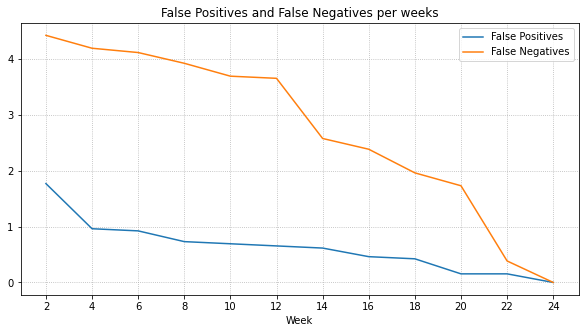

In [275]:
from matplotlib import pyplot as pl
X = [week[21:] for week in False_Negatives.columns[1:]]


fig, ax = pl.subplots(figsize=(10,5))
ax.plot(X,average_false_positives_per_week,label="False Positives")
ax.plot(X,average_false_negatives_per_week,label="False Negatives")

#pl.plot(X,average_false_positives_per_week,average_false_negatives_per_week)
ax.grid(True,linestyle=":")
ax.set_xlabel("Week")
ax.set_title("False Positives and False Negatives per weeks")
ax.legend()
pl.show()

Christmas : Week 10 \
MLK Day : Week 14\
Trade Deadline : Week 16\
All Star Week-end : Week 18\
End of the season : Week 24-25